In [1]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import pyproj
import time
import sys
sys.path.append("..")

import geopandas as gpd
from geopandas.geoseries import GeoSeries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.animation as animation
from shapely.geometry import Point
from datetime import datetime
from dateutil.relativedelta import relativedelta
import imageio
from IPython.display import Image
get_ipython().magic(u'matplotlib inline')
from matplotlib.patches import Ellipse

%load_ext autoreload
%autoreload 2
%matplotlib inline

from connect_db import db_connection

# filter annyoing warning from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
username='bdelpapa'

In [3]:
cred_location = '/mnt/data/'+username+'/utils/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [4]:
# Load maps data 

# load data from TPT (use this from now on)
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
territories =  r"/mnt/data/shared/Tus_28districts.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"

In [5]:
# Load files and select only Tuscany
# reg, pro, mun are for the whole italy
# ter is only for tuscany, and already in lat,lon coords

gdf_reg = gpd.read_file(regions)
gdf_pro = gpd.read_file(provinces)
gdf_ter = gpd.read_file(territories)
gdf_mun = gpd.read_file(municipalities)

# Convert coordinates in WGS84 to Lat Lon format 
# see http://geopandas.org/projections.html
gdf_reg['geometry'] = gdf_reg['geometry'].to_crs(epsg=4326)
gdf_pro['geometry'] = gdf_pro['geometry'].to_crs(epsg=4326)
gdf_mun['geometry'] = gdf_mun['geometry'].to_crs(epsg=4326)

# important cities 
important_cities_tuscany = r"/mnt/data/shared/important_cities.csv"
df_impcit = pd.read_csv(important_cities_tuscany)

# 9 is for Tuscany only
gdf_reg_tus = gdf_reg[gdf_reg["COD_REG"] == 9] 
gdf_pro_tus = gdf_pro[gdf_pro["COD_REG"] == 9]
gdf_ter_tus = gdf_ter # this one is already Tuscany only
gdf_mun_tus = gdf_mun[gdf_mun["COD_REG"] == 9]

In [6]:
# function to run queries for the heatmap 
# this query already removes the customers from tuscany.excluded_customers

def query_count_territory(gdf_ter_map,
                          min_date = '2017-05-01 00:00:00', 
                          max_date = '2018-02-28 23:59:59'):
    '''
    Run the query for unique customers in each territory in a given time window
    
    Params:
        gdf_ter_map: GeoDataFrame with the field 'rown', loaded from /mnt/data/shared
        min_date: minimum date, in the yyy-mm-dd hh:mm:ss format
        max_date: maximum date, in the same format
        
    Returns:
        gdf_merged_map: GeoDataFrame with the unique counts for each territory
    '''

    query="""
    select count(distinct customer_id), location_dictionary.territory
    from tuscany.vodafone
    join tuscany.location_dictionary on location_dictionary.location_id = vodafone.location_id
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    and territory is NOT NULL
    group by tuscany.location_dictionary.territory;
    """
    df_count_territory = db.sql_query_to_data_frame(query, cust_id=True)
    
    gdf_merged_map = gdf_ter_map.merge(df_count_territory.astype(int), how = 'inner', left_on='rown', right_on='territory')
    
    return gdf_merged_map

## Heatmaps per seasonality

In [10]:
# queries for each 'month' (takes around 2 min)

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with heatmaps for every month
heatmaps_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]

    gdf_month = query_count_territory(gdf_ter_tus, min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    heatmaps_per_month[cur_month] = gdf_month  
    print(cur_month)
    
with open('heatmap_month/heatmaps_per_month.pickle', 'wb') as handle:
    pickle.dump(heatmaps_per_month, handle, protocol=pickle.HIGHEST_PROTOCOL)

2017-04-30 23:59:59
2017-05-31 23:59:59
2017-06-30 23:59:59
2017-07-31 23:59:59
2017-08-31 23:59:59
2017-09-30 23:59:59
2017-10-31 23:59:59
2017-11-30 23:59:59
2017-12-31 23:59:59
2018-01-31 23:59:59


In [16]:
# queries for each 'seasonality'

# # create dictionary with heatmaps for every month
# heatmaps_per_season = {}

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = str(datetime(2017, 4, 30, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 5, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Pre-summer'] = gdf_season  
print('Pre-summer')

start_dt = str(datetime(2017, 5, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 8, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Summer'] = gdf_season  
print('Summer')

start_dt = str(datetime(2017, 8, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2017, 10, 31, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Post-summer'] = gdf_season  
print('Post-summer')

start_dt = str(datetime(2017, 10, 31, hour=23, minute=59, second=59))
end_dt = str(datetime(2018, 2, 28, hour=23, minute=59, second=59))
gdf_season = query_count_territory(gdf_ter_tus, min_date = start_dt, max_date = end_dt)
heatmaps_per_season['Winter'] = gdf_season  
print('Winter')

with open('../heatmap_month/heatmaps_per_season.pickle', 'wb') as handle:
    pickle.dump(heatmaps_per_season, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('../heatmap_month/heatmaps_per_season.pickle', 'rb') as handle:
    heatmaps_per_season = pickle.load(handle)

In [7]:
# normalize the seasonality maps

heatmaps_per_season['Pre-summer']['count'] = heatmaps_per_season['Pre-summer']['count']
heatmaps_per_season['Summer']['count'] = heatmaps_per_season['Summer']['count']/3
heatmaps_per_season['Post-summer']['count'] = heatmaps_per_season['Post-summer']['count']/2
heatmaps_per_season['Winter']['count'] = heatmaps_per_season['Winter']['count']/4

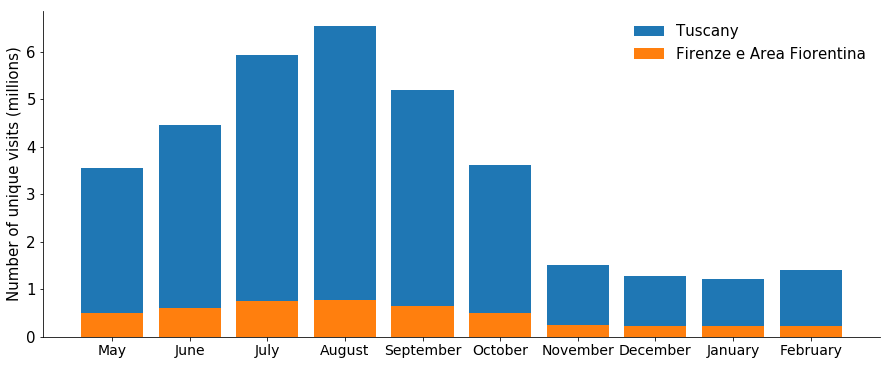

In [11]:
names = list(heatmaps_per_month.keys())
values = []
values_florence = []
for hm in heatmaps_per_month.values():
    values.append(hm['count'].sum())
    values_florence.append(int(hm.loc[hm['District'] == 'Firenze.e.Area.Fiorentina']['count']))

fig = plt.figure(figsize=(15, 6))
ax = plt.subplot(1,1,1)
plt.bar(range(len(names)), np.array(values)/1000000, tick_label=names, label='Tuscany')
plt.bar(range(len(names)), np.array(values_florence)/1000000, tick_label=names, label='Firenze e Area Fiorentina')
plt.ylabel('Number of unique visits (millions)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)
plt.legend(loc='best', frameon=False, fontsize=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [33]:
# heatmap plots for each month

# find overall minimum and maximum
min_count_month = []
max_count_month = []
for month, gdf_month in heatmaps_per_month.items():   
    min_count_month.append(gdf_month['count'].min())
    max_count_month.append(gdf_month['count'].max())
min_count = np.array(min_count_month).min()
min_logcount = np.log(min_count)
max_count = np.array(max_count_month).max()
max_logcount = np.log(max_count)

# create monthly heatmaps
for month, gdf_month in heatmaps_per_month.items():
    
    fig = plt.figure(figsize=(11, 9))
    ax = fig.add_subplot(1, 1, 1)    
    
    heatmap_replace_zeros(gdf_month)
    heatmap_plot(gdf_month, ax, clog=[min_logcount, max_logcount], title=month)  
    important_cities(df_impcit)
    
    plt.axis('off')
    plt.savefig(r"/mnt/data/shared/heatmaps/monthly/"+month+".png")

NameError: name 'heatmaps_per_month' is not defined

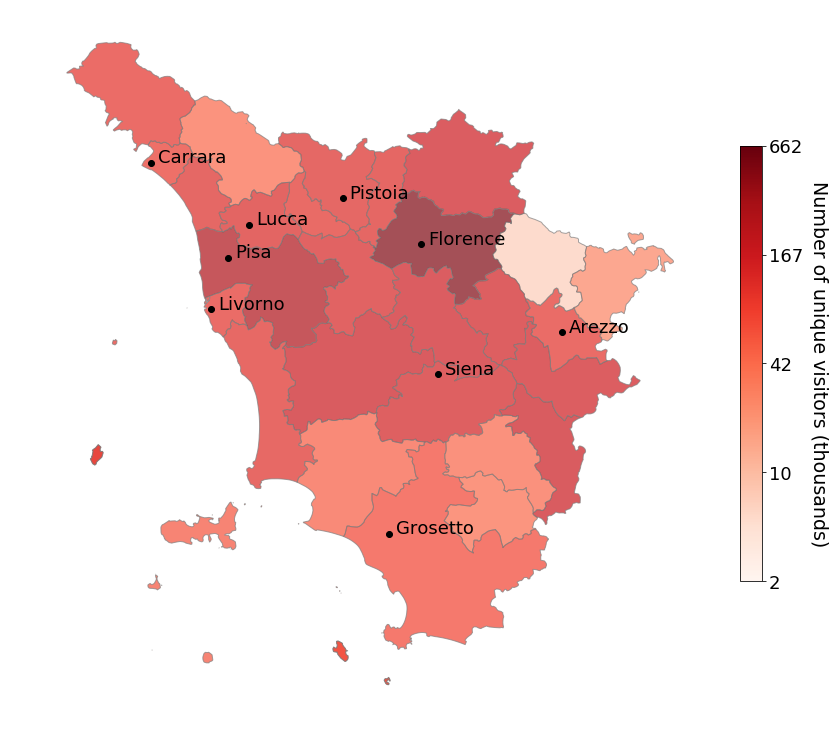

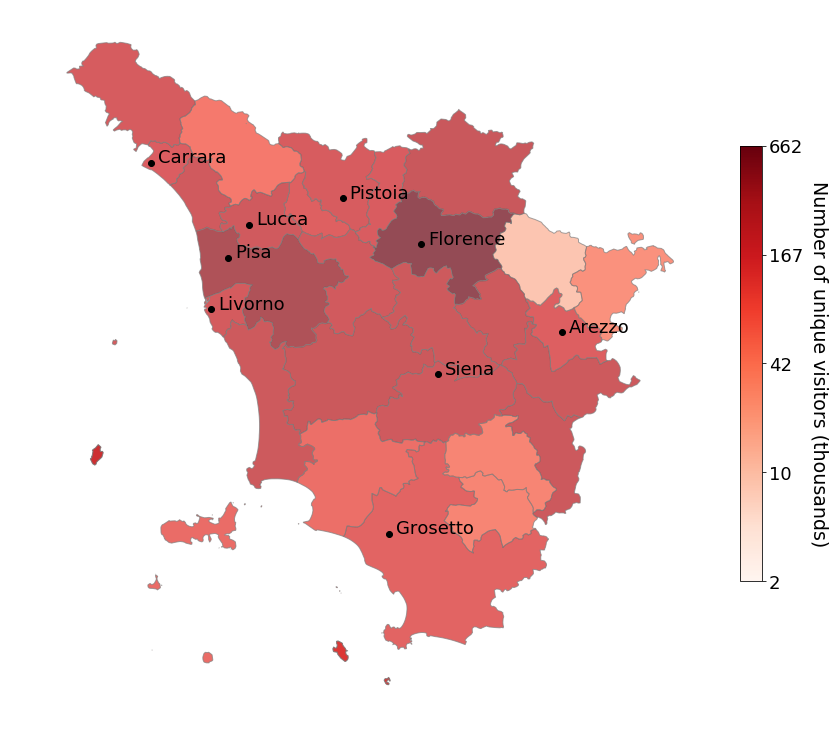

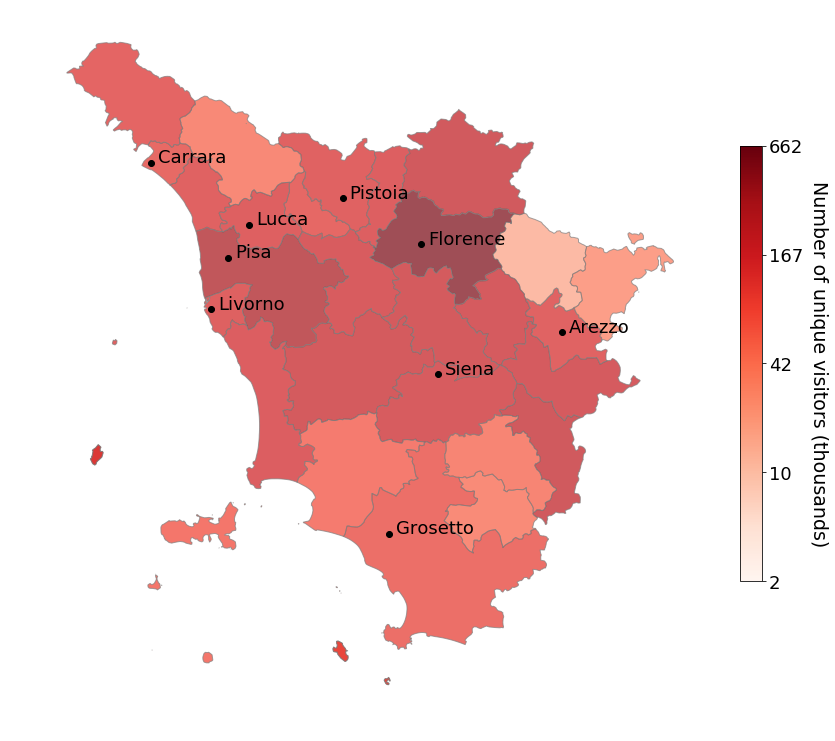

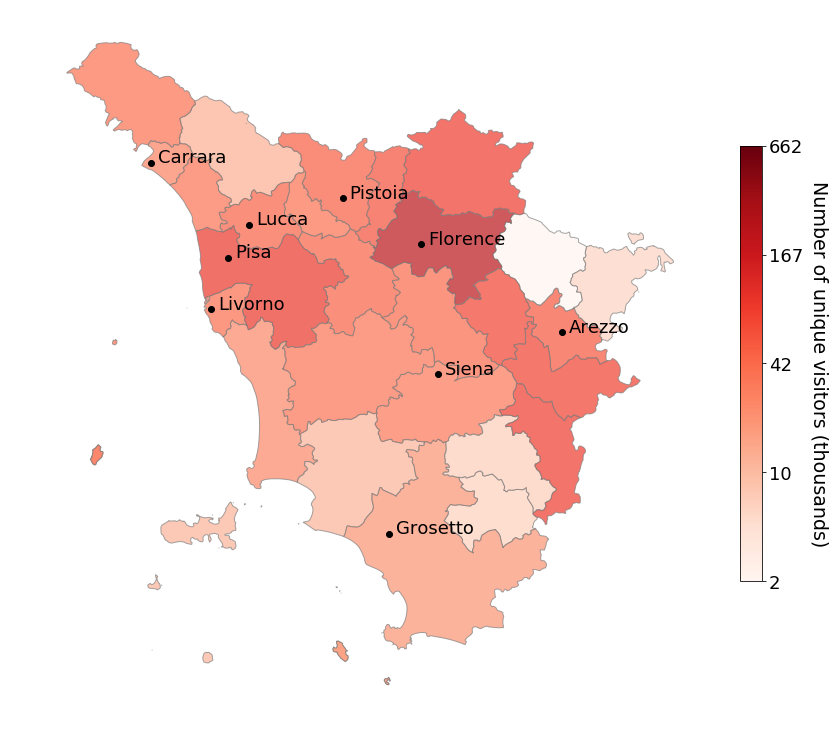

In [40]:
# heatmap plots for each season

# plot heatmaps
sys.path.append("../new_codebase/viz")
from heatmaps import Heatmap

# find overall minimum and maximum
min_count_season = []
max_count_season = []
for season, gdf_season in heatmaps_per_season.items():   
    min_count_season.append(gdf_season['count'].min())
    max_count_season.append(gdf_season['count'].max())
min_count = np.array(min_count_season).min()
min_logcount = np.log(min_count)
max_count = np.array(max_count_season).max()
max_logcount = np.log(max_count)

# create monthly heatmaps
for season, gdf_season in heatmaps_per_season.items():
    
    heatmap = Heatmap(gdf_season)
    heatmap.plot_log('count',
                     log_min=min_logcount,
                     log_max=max_logcount)  
    heatmap.colorbar()
    heatmap.important_cities()
    heatmap.save(r"/mnt/data/shared/heatmaps/monthly/"+season+".png")

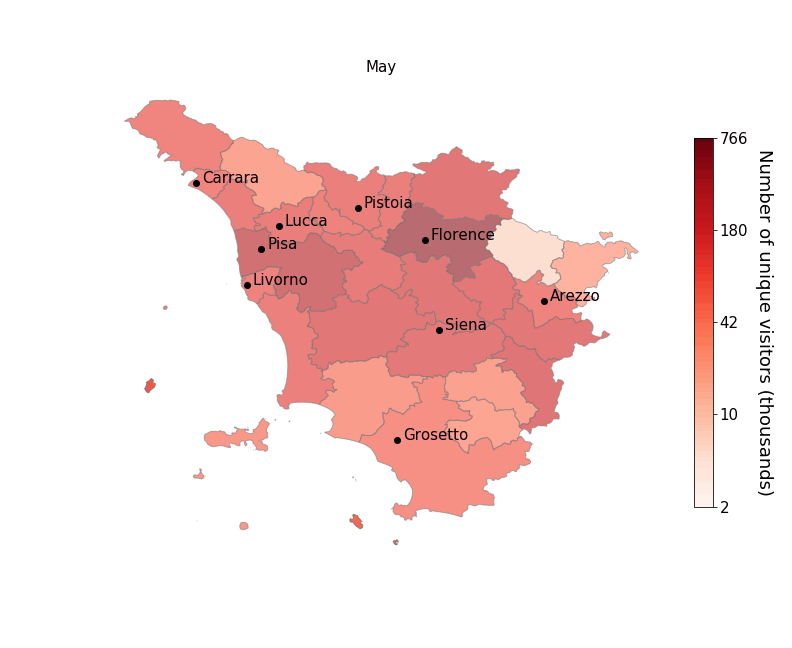

In [21]:
# creat gif with monthly heatmaps

filenames = []
for month in heatmaps_per_month.keys():
    filenames.append("/mnt/data/shared/heatmaps/monthly/"+month+".png")

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/mnt/data/shared/heatmaps/monthly/movie.gif', images, duration=2)

Image(filename="/mnt/data/shared/heatmaps/monthly/movie.gif")

## Histograms of nationalities per month

In [12]:
# query to get the nationalities that visited Tuscany

def query_count_nationality(min_date = '2017-05-01 00:00:00', 
                            max_date = '2018-02-28 23:59:59'):
    
    query="""
    select mcc, count(distinct customer_id) as num_unique_cus
    from tuscany.vodafone
    where time_stamp between '"""+min_date+"""' and '"""+max_date+"""'
    and customer_id not in (select customer_id from tuscany.excluded_customers)
    group by mcc
    """

    number_of_cus_per_country = db.sql_query_to_data_frame(query, cust_id=True)
    
    return number_of_cus_per_country

In [15]:
# queries for each 'season' (takes a while... go have a coffee)

# create months datetime list
# minimum date is '2017-05-01 00:00:00'
# maximun date is '2017-28-02 23:59:59'
start_dt = datetime(2017, 4, 30, hour=23, minute=59, second=59)
end_dt = datetime(2018, 2, 28, hour=23, minute=59, second=59)
months_dt = []
for i in pd.date_range(start=start_dt, end=end_dt, freq='1M'):
    months_dt.append(str(i + relativedelta(hour=23, minute=59, second=59)))
    
# create dictionary with nationalities for every month
nationality_per_month = {}
for i in range(len(months_dt)-1):
    
    month_start = months_dt[i]
    month_end = months_dt[i+1]
    
    nat_month = query_count_nationality(min_date = month_start, max_date = month_end)
    cur_month = datetime.strptime(months_dt[i+1], "%Y-%m-%d %H:%M:%S").strftime("%B")
    
    nationality_per_month[cur_month] = nat_month  
    print(cur_month)

with open('heatmap_month/natoinality_per_month.pickle', 'wb') as handle:
    pickle.dump(nationality_per_month, handle, protocol=pickle.HIGHEST_PROTOCOL)

May
June
July
August
September
October
November
December
January
February


In [35]:
with open('heatmap_month/natoinality_per_month.pickle', 'rb') as handle:
    nationality_per_month = pickle.load(handle)

In [107]:
nationality_per_month['May'].head()

mcc  num_unique_cus
0  262           91034
1  460           37303
2  302           17288
3  220            1860
4  452             298

In [36]:
# get the country names from the MCC file and create a column with country name

def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

mcc=pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')
mcc_country=mcc.drop_duplicates("MCC", keep='first')[['MCC', 'Country']]
mcc_country['MCC']=mcc_country['MCC'].astype(int)
mcc_country['Country']=mcc_country.apply(clean_guam,1)


for month, df_nat in nationality_per_month.items():
    df_nat['mcc'] = df_nat['mcc'].astype(int)
    nationality_per_month[month] = df_nat.merge(mcc_country, how = 'inner', left_on='mcc', right_on='MCC')

nationality_per_month['May'].head()

mcc  num_unique_cus  MCC   Country
0  262           91034  262   Germany
1  460           37303  460     China
2  302           17288  302    Canada
3  220            1860  220    Serbia
4  452             298  452  Viet Nam

In [37]:
# shrink the data for the top countries (the others should be in a separate field called others)

for month in nationality_per_month.keys():
    nationality_per_month[month] = nationality_per_month[month].sort_values(by=['num_unique_cus'], ascending=False)
    nationality_per_month[month] = nationality_per_month[month].groupby('Country', as_index=False).aggregate('sum')
    nationality_per_month[month] = nationality_per_month[month].drop(['mcc', 'MCC'], axis=1)

In [38]:
#nationality_per_month[month] = nationality_per_month[month].rename(columns={"num_unique_cus": 'May'})    



# find top countries overall
df_counts = pd.DataFrame(nationality_per_month['May']['Country'], columns=['Country'])
for month in list(nationality_per_month.keys())[:]:
    df_counts = df_counts.merge(nationality_per_month[month], how='outer', left_on='Country', right_on='Country')
    df_counts = df_counts.rename(columns={'num_unique_cus': month})
df_counts = df_counts.fillna(0)


# group countries

N_TOPLOT = 9

# find countries with biggest counts
df_counts['Sum'] = df_counts.sum(axis=1)
df_counts = df_counts.sort_values('Sum', ascending=False)
df_counts = df_counts.head(N_TOPLOT)
df_counts = df_counts.drop(columns=['Sum'])

df_counts

Country      May      June      July    August  September  \
65          Germany  91034.0  176581.0  167106.0  225495.0   197097.0   
176   United States  97024.0  134223.0   97703.0   67889.0   121167.0   
59           France  64249.0   54109.0  108757.0  190377.0    67120.0   
175  United Kingdom  65661.0   86980.0  102705.0  120165.0    92444.0   
122     Netherlands  49212.0   58402.0  110960.0  132027.0    66362.0   
37            China  37303.0   38210.0   48806.0   48896.0    37629.0   
159     Switzerland  36765.0   41289.0   76754.0   55264.0    49606.0   
152           Spain  25563.0   37191.0   45858.0   63121.0    41021.0   
18          Belgium  13861.0   16521.0   62424.0   49932.0    20306.0   

      October  November  December  January  February  
65   100941.0   32821.0   21712.0  21354.0   18846.0  
176  102171.0   46956.0   30485.0  31951.0   27875.0  
59    55330.0   32840.0   33526.0  30495.0   32030.0  
175   55711.0   20692.0   17731.0  16349.0   19729.0  
122   45553.0   24024.0   24542.0  27216.0   41201.0  
37    42639.0   27980.0   19552.0  17273.0   32487.0  
159   45776.0    7804.0   11058.0   8257.0    5195.0  
152   36216.0   20262.0   21125.0  18684.0   18940.0  
18     8677.0    4662.0    3071.0   3211.0    3673.0

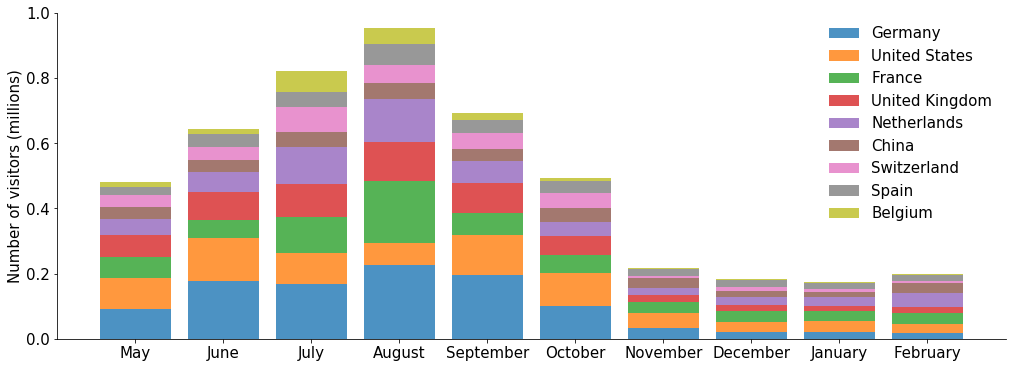

In [41]:
# plot distribution of countries per month

fig = plt.figure(figsize=(17, 6))
ax = plt.subplot(1,1,1)

values_bottom = 0
countries = df_counts['Country'].tolist()
months = nationality_per_month.keys()
for country in countries:
    
    values = df_counts.loc[df_counts['Country'] == country]
    values = np.array(values.drop(columns=['Country']))[0]/1000000
    ind = np.arange(len(months))
           
    plt.bar(ind, values, bottom=values_bottom, label=country, alpha=0.8)  
    values_bottom += values

    
plt.ylabel('Number of visitors (millions)', fontsize=15)
#plt.title('Number of visitors per country', fontsize=15)
plt.xticks(ind, months, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', frameon=False, fontsize=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Where are turists coming from 

 - This can be done by looking at the municipality where they first show up in Tuscany

In [23]:
### commune of first arrival in Tuscany
query="""
select count(distinct customer_nr), pro_com as com_arvl_tusc
from tuscany.customer_feature
join tuscany.location_dictionary on location_dictionary.location_id = customer_feature.loc_arvl_tusc
group by pro_com
"""
df_arrival_tus = db.sql_query_to_data_frame(query, cust_id=True)
with open('../heatmap_month/df_arrival_tus.pickle', 'wb') as handle:
    pickle.dump(df_arrival_tus, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrival_tus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 2 columns):
count            279 non-null int64
com_arvl_tusc    279 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB


In [24]:
### commune of first arrival in Italy
query="""
select count(distinct customer_nr), pro_com as com_arvl_italy
from tuscany.customer_feature
join tuscany.location_dictionary on location_dictionary.location_id = customer_feature.loc_arvl_italy
group by pro_com
"""
df_arrival_ita = db.sql_query_to_data_frame(query, cust_id=True)
with open('../heatmap_month/df_arrival_ita.pickle', 'wb') as handle:
    pickle.dump(df_arrival_ita, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrival_ita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 2 columns):
count             5910 non-null int64
com_arvl_italy    5910 non-null object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


(9.552467742534965, 12.505587108273097, 42.12652066388761, 44.5844306661525)

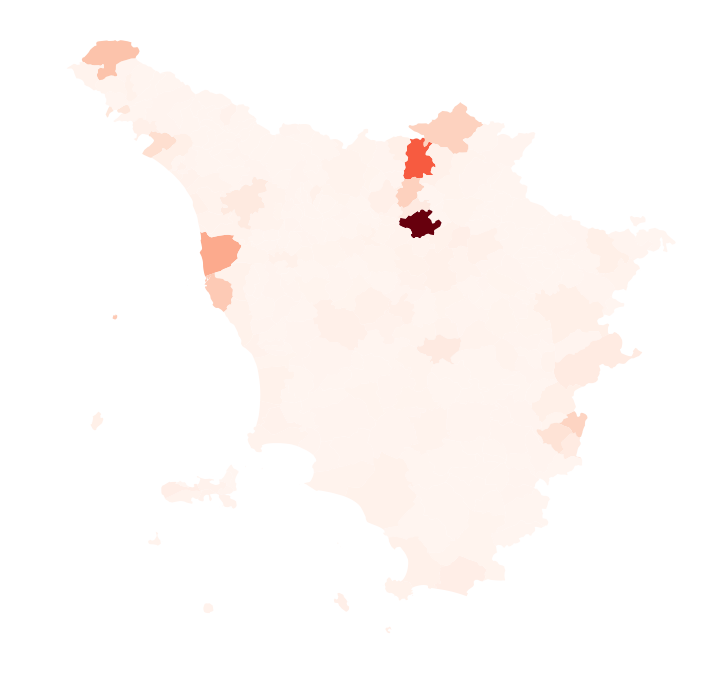

In [34]:
# heatmap of entrance municipalities (arrival in Tuscany!)

gdf_mun_merged = gdf_mun.merge(df_arrival_tus.astype(int), how = 'inner', left_on='PRO_COM', right_on='com_arvl_tusc')

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(1,1,1)
gdf_mun_merged.plot(column='count', cmap='Reds', ax=ax, alpha=1)
plt.axis('off')

(6.031933348276, 19.115069605015037, 34.91378733591511, 47.671688331985)

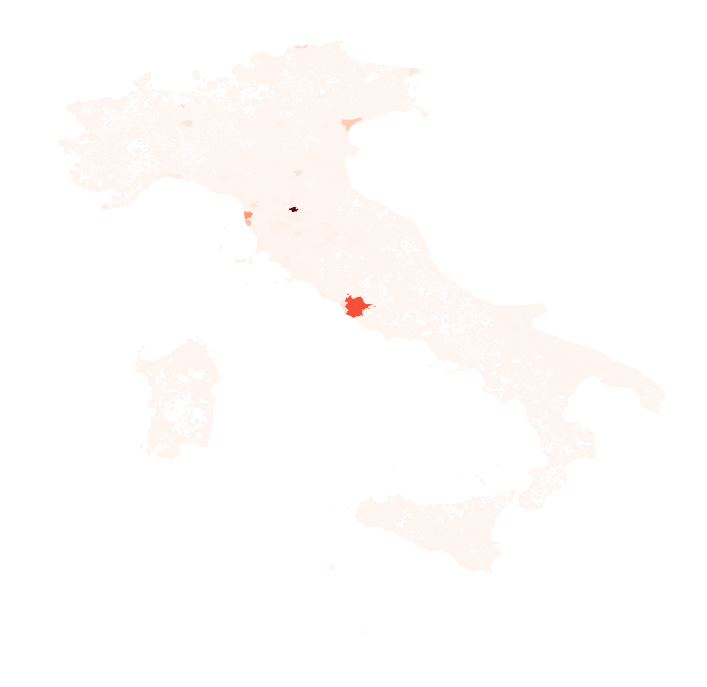

In [36]:
# heatmap of entrance municipalities (arrival in Italy!)

gdf_mun_merged_ita = gdf_mun.merge(df_arrival_ita.astype(int), how = 'inner', left_on='PRO_COM', right_on='com_arvl_italy')

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(1,1,1)
gdf_mun_merged_ita.plot(column='count', cmap='Reds', ax=ax, alpha=1)
plt.axis('off')

In [71]:
### run query for the full sample
# removed all the customers we discussed should be removed
query = """
select locations 
from tuscany.customer_arrays
where customer_id not in (select customer_id from tuscany.excluded_customers)
"""
df_trips_trunc = db.sql_query_to_data_frame(query, cust_id=True)
with open('../heatmap_month/df_trips_trunc.pickle', 'wb') as handle:
    pickle.dump(df_trips_trunc, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_trips_trunc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194002 entries, 0 to 6194001
Data columns (total 1 columns):
locations    object
dtypes: object(1)
memory usage: 47.3+ MB


In [86]:
# NOT the trunc data

### run query for the full sample
# removed all the customers we discussed should be removed
query2 = """
select locations 
from tuscany.customer_arrays
"""
df_trips = db.sql_query_to_data_frame(query2, cust_id=True)
with open('heatmap_month/df_trips.pickle', 'wb') as handle:
    pickle.dump(df_trips, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194002 entries, 0 to 6194001
Data columns (total 1 columns):
locations    object
dtypes: object(1)
memory usage: 47.3+ MB


In [7]:
with open('heatmap_month/df_trips.pickle', 'rb') as handle:
    df_trips = pickle.load(handle)
with open('heatmap_month/df_trips_trunc.pickle', 'rb') as handle:
    df_trips_trunc = pickle.load(handle)

In [8]:
# replace str of locations by list of strs with pro_com
# (takes a minute for the full dataset)

# str to list of PRO_COM
tic = time.time()
df_trips['locations'] = df_trips['locations'].str.split(', ').tolist()
toc = time.time()
print('Number of individual trips:', df_trips.shape[0])

Number of individual trips: 6194002


In [9]:
# remove trips with only one municipality

df_trips = df_trips[df_trips['locations'].apply(len) > 1] 
df_trips = df_trips.reset_index()[['locations']]         # this reduces the size of the DataFrame (a bit)

df_trips.shape
print('Reduced number of individual trips:', df_trips.shape[0])

Reduced number of individual trips: 5781464


In [58]:
# A bit of descriptives

df_trips_len = df_trips['locations'].apply(len)
print('Mean number of visited municipalities =', df_trips_len.mean())
print('Median number of visited municipalities =', int(df_trips_len.median()))
print('Min number of visited municipalities =', df_trips_len.min())
print('Max number of visited municipalities =', df_trips_len.max())

Mean number of visited municipalities = 31.701101831646795
Median number of visited municipalities = 18
Min number of visited municipalities = 2
Max number of visited municipalities = 472


In [10]:
# find out arrival municipality (arrival in Italy!)

def arrival_mun(trip):
    
    return trip[0]

df_arrival_mun = df_trips['locations'].apply(arrival_mun)
df_arrival_fre = pd.DataFrame(df_arrival_mun.value_counts())
df_arrival_fre['PRO_COM'] = df_arrival_fre.index

df_arrival_fre.head()

locations PRO_COM
48017     633929   48017
58091     514477   58091
50026     297984   50026
27042     175191   27042
49009     171801   49009

In [ ]:
# heatmap of entrance municipalities (arrival in Italy!)

gdf_mun_merged = gdf_mun.merge(df_arrival_fre.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1,1,1)
gdf_mun_merged['log'] = np.log(gdf_mun_merged['locations'])
gdf_mun_merged.plot(column='log', cmap='Reds', ax=ax, alpha=1)
plt.axis('off')

(6.0319333482760005, 19.115069605015037, 34.91378733591511, 47.671688331985)

(6.0319333482760005, 19.115069605015037, 34.91378733591511, 47.671688331985)

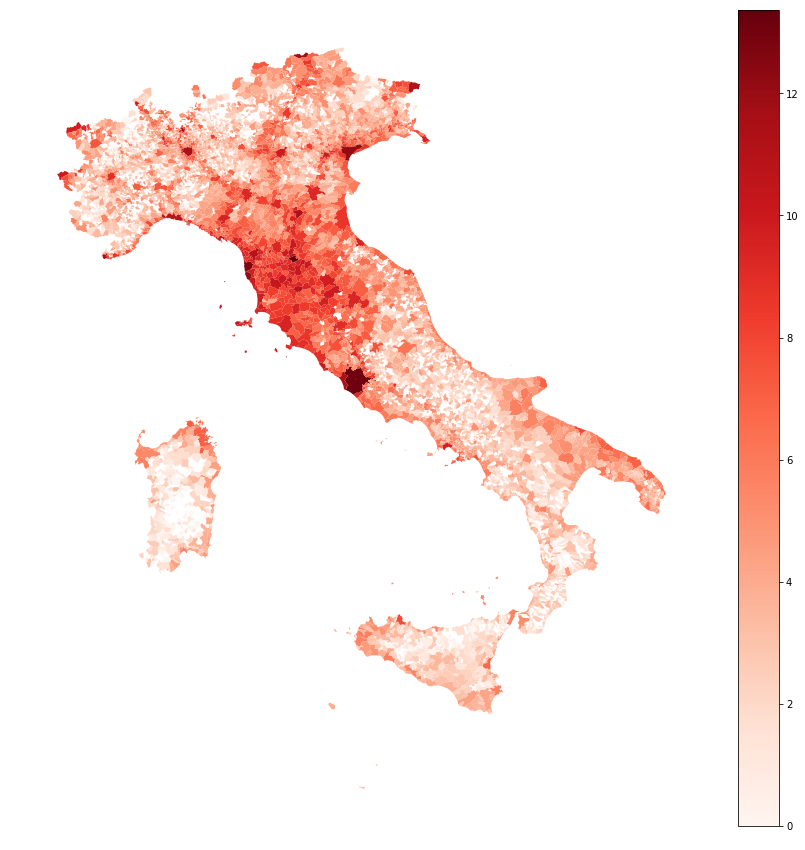

In [80]:
# heatmap of entrance municipalities (arrival in Italy!)

gdf_mun_merged_trunc = gdf_mun.merge(df_arrival_fre_trunc.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1,1,1)
gdf_mun_merged_trunc['log'] = np.log(gdf_mun_merged_trunc['locations'])
gdf_mun_merged_trunc.plot(column='log', cmap='Reds', ax=ax, alpha=1, legend=True)
plt.axis('off')

(9.552467742534965, 12.5055871082731, 42.12652066388761, 44.5844306661525)

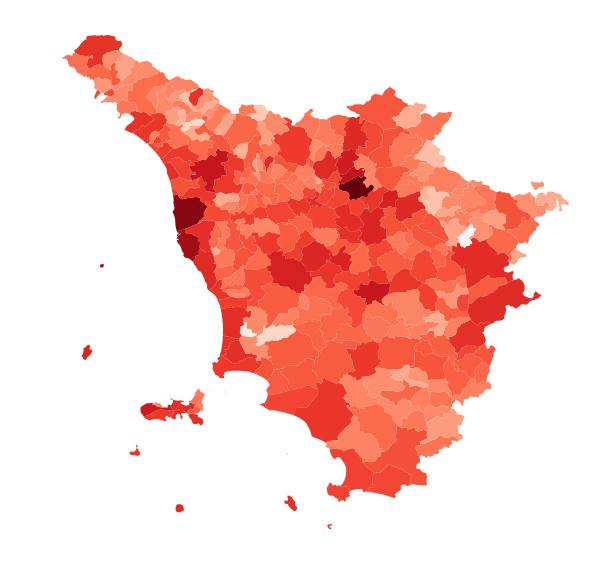

In [55]:
# heatmap of entrance municipalities (arrival in Italy)

gdf_mun_tus_merged_trunc = gdf_mun_tus.merge(df_arrival_fre_trunc.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
gdf_mun_tus_merged_trunc['log'] = np.log(gdf_mun_tus_merged_trunc['locations'])
gdf_mun_tus_merged_trunc.plot(column='log', cmap='Reds', ax=ax)
plt.axis('off')

In [ ]:
# heatmap of entrance municipalities (arrival in Italy)

gdf_mun_tus_merged = gdf_mun_tus.merge(df_arrival_fre.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
gdf_mun_tus_merged['log'] = np.log(gdf_mun_tus_merged['locations'])
gdf_mun_tus_merged.plot(column='log', cmap='Reds', ax=ax)
plt.axis('off')

In [56]:
# find out arrival municipality (arrival in Tuscany!)

def arrival_mun_tus(trip):
    
    return [int(m) for m in trip if int(m) in gdf_mun_tus['PRO_COM'].tolist()]

tic = time.time()
df_trips_tus = df_trips['locations'].apply(arrival_mun_tus)
toc = time.time()
print(toc-tic, 'seconds')

with open('heatmap_month/df_trips_tus.pickle', 'wb') as handle:
    pickle.dump(df_trips_tus, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_trips_tus.head()

4646.6251010894775 seconds


0                                              [46013]
1    [51001, 51034, 48038, 48028, 48036, 51002, 510...
2    [48021, 52023, 52006, 52013, 52032, 52022, 520...
3    [48018, 48053, 48043, 48017, 48014, 48028, 480...
4                                       [52032, 51018]
Name: locations, dtype: object

In [215]:
with open('heatmap_month/df_trips_tus.pickle', 'rb') as handle:
    df_trips_tus = pickle.load(handle)

In [218]:
# filter arrival municipality

df_entrance_tus = df_trips_tus.apply(arrival_mun)

In [219]:
# count the number of entrances per municipality

df_entrance_tus_counts = pd.DataFrame(df_entrance_tus.value_counts())
df_entrance_tus_counts['PRO_COM'] = df_entrance_tus_counts.index
df_entrance_tus_counts.columns = ['counts', 'PRO_COM']
df_entrance_tus_counts.head()

counts  PRO_COM
48017  857310    48017
48002  608771    48002
50026  327763    50026
45014  250904    45014
48005  197797    48005

(9.552467742534965, 12.5055871082731, 42.12652066388761, 44.5844306661525)

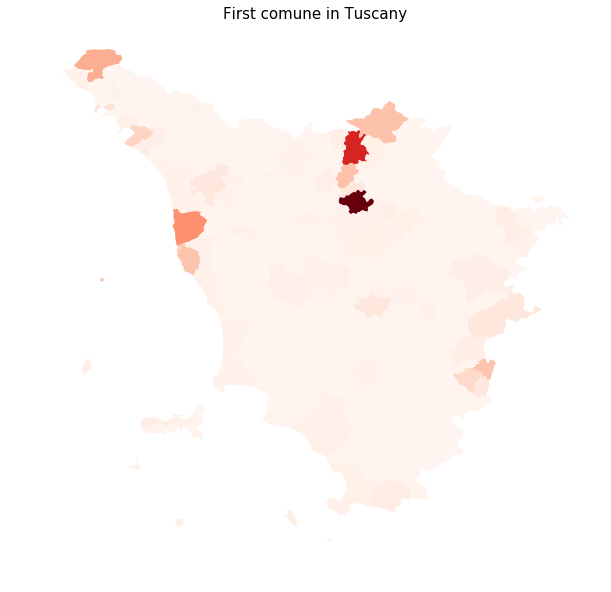

In [220]:
# heatmap of entrance municipalities (arrival in Tuscany!)

gdf_mun_tus_merged = gdf_mun_tus.merge(df_entrance_tus_counts.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
gdf_mun_tus_merged.plot(column='counts', cmap='Reds', ax=ax)
plt.title('First comune in Tuscany', fontsize=15)
plt.axis('off')

## Arrivals by type of transportation

In [8]:
# query for starting lat and lon in Italy

query = """
select start_lat, start_lon, mon_arvl_tusc, day_arvl_tusc
from tpt.tuscany.customer_feature
where customer_id not in (select customer_id from tuscany.excluded_customers)
order by tpt.tuscany.customer_feature.mon_arvl_tusc
"""
df_arrivals = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals.pickle', 'wb') as handle:
    pickle.dump(df_arrivals, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals.head()

start_lat  start_lon mon_arvl_tusc day_arvl_tusc
0  41.883400  12.489800             1             1
1  41.967900  12.409600             1             1
2  43.793100  11.218200             1             1
3  41.883400  12.489800             1             1
4  44.162200   9.614600             1             1

(6.031933348276, 19.115069605015037, 34.91378733591511, 47.671688331985)

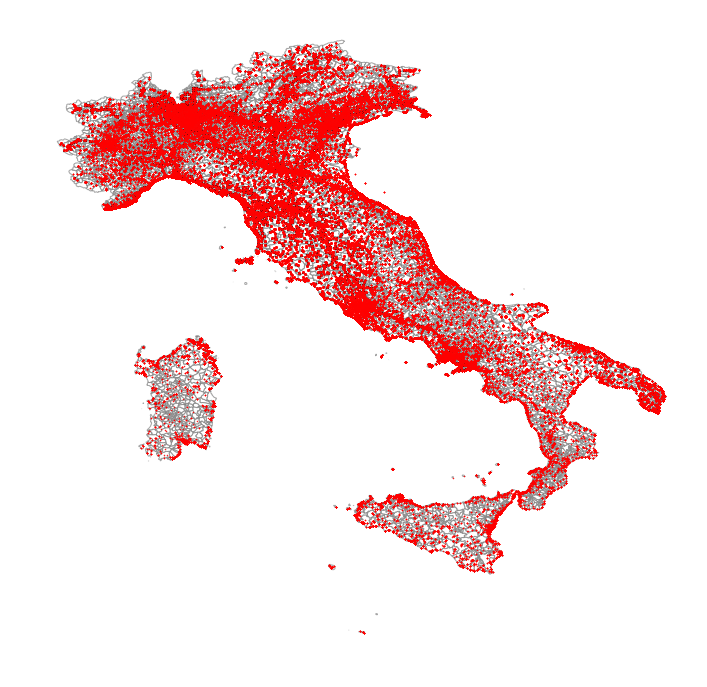

In [12]:
fig  = plt.figure(figsize=(12, 12))
ax = plt.subplot(1,1,1)

gdf_mun.plot(ax=ax, color='white', edgecolor='gray', alpha=0.7)

plt.plot(df_arrivals['start_lon'].iloc[:], df_arrivals['start_lat'].iloc[:], 'ro', markersize=0.5)


plt.axis('off')

In [267]:
# query for starting lat and lon in Tuscany

query = """
select lat, lon, coast, pisa, firenze
from tpt.tuscany.customer_feature as c
inner join tpt.tuscany.location_features as l
on c.loc_arvl_tusc = l.location_id
"""
df_arrivals_tus = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals_tusc.pickle', 'wb') as handle:
    pickle.dump(df_arrivals_tus, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals_tus.head()

lat        lon coast  pisa firenze
0  43.403000  10.873800     0  None    None
1  44.030100  10.076100     0  None    None
2  43.766900  11.281400     0  None       1
3  43.770000  11.272400     0  None       1
4  42.983300  11.875000     0  None    None

In [272]:
df_arrivals_tus.firenze.sum()

Decimal('1127668')

In [15]:
with open('heatmap_month/df_arrivals_tusc.pickle', 'rb') as handle:
    df_arrivals_tus = pickle.load(handle)

NameError: name 'df_arrivals_tus' is not defined

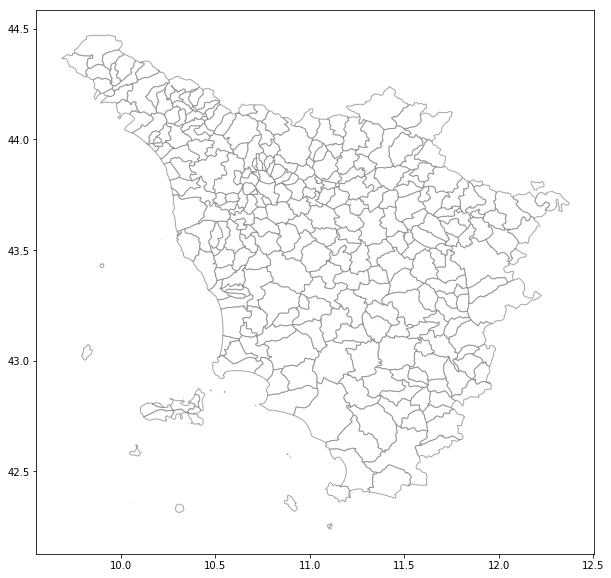

In [60]:
# plot map of arrival locations in Tuscany

fig  = plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

gdf_mun_tus.plot(ax=ax, color='white', edgecolor='gray', alpha=0.7)

plt.plot(df_arrivals_tus['lon'].iloc[:], df_arrivals_tus['lat'].iloc[:], 'ro', markersize=0.5)

plt.axis('off')

In [260]:
# plot heatmap of arrival locations in Tuscany

query="""
select pro_com
from tpt.tuscany.location_dictionary as l
inner join tpt.tuscany.customer_feature as c
on l.location_id = c.loc_arvl_tusc
where c.customer_id not in (select customer_id from tuscany.excluded_customers)
"""
df_arrivals_tus_procom = db.sql_query_to_data_frame(query, cust_id=True)

with open('heatmap_month/df_arrivals_tus_procom.pickle', 'wb') as handle:
    pickle.dump(df_arrivals_tus_procom, handle, protocol=pickle.HIGHEST_PROTOCOL)
df_arrivals_tus_procom.head()

pro_com
0   51030
1   48053
2   47011
3   50026
4   46018

In [42]:
with open('heatmap_month/df_arrivals_tus_procom.pickle', 'rb') as handle:
    df_arrivals_tus_procom = pickle.load(handle)

In [43]:
# coutns and sanity check

df_entrance_procom = pd.DataFrame(df_arrivals_tus_procom['pro_com'].value_counts())
df_entrance_procom['PRO_COM'] = df_entrance_procom.index
df_entrance_procom.columns = ['counts', 'PRO_COM']
df_entrance_procom.head()

counts PRO_COM
48017  1127670   48017
48002   609075   48002
50026   340899   50026
45014   251187   45014
49009   227604   49009

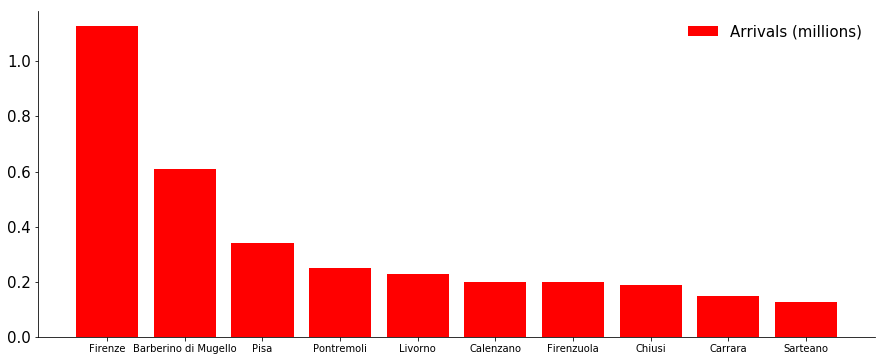

In [50]:
# histogram of arrivals

N_COMUNES = 10

gdf_entrance = gdf_mun_tus.merge(df_entrance_procom.astype(int), how = 'inner', left_on='PRO_COM', right_on='PRO_COM')
gdf_entrance = gdf_entrance.sort_values(by=['counts'], ascending=False)

names = gdf_entrance['COMUNE'][:N_COMUNES].tolist()
procoms = gdf_entrance['PRO_COM'][:N_COMUNES].tolist()
values = gdf_entrance['counts'][:N_COMUNES].tolist()

fig = plt.figure(figsize=(15, 6))
ax = plt.subplot(1,1,1)
plt.bar(range(len(procoms)), np.array(values)/1000000, tick_label=names, color='r', label='Arrivals (millions)')
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)
plt.legend(loc='best', frameon=False, fontsize=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [62]:
# who arrives in a coast or an airport?

df_arrivals_tus['florence'].astype(int).sum()

1259

In [258]:
# is it easy for you to write a function which given the list of 
# communes as an array or something can plot the trajectory on the italian map?

def function_for_KM(list_of_comunes=False):
    '''
    Parameters:
    
        list_of_comunes: list of pro_com (as ints)    
    '''
    
    # comune centroids 
    df_centroids = pd.read_csv(r"/mnt/data/shared/comune_centroids.csv")
        
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot(1,1,1)
    
    gdf_mun.plot(ax=ax, color='white', edgecolor='gray', alpha=0.5)
    
    if list_of_comunes is not False:
        
        trip = pd.DataFrame(list_of_comunes, columns=['PRO_COM'])
        trip = trip.merge(df_centroids, how='inner', left_on='PRO_COM', right_on='pro_com')
        
    plt.plot(trip['lat'], trip['lon'], '-o')
    plt.axis('off')


#trip_example = [1001, 1002, 1003, 1004, 94020]   
#function_for_KM(list_of_comunes=trip_example)   
    

In [233]:
query='''
select com_locs_new from tuscany.customer_arrays
where customer_nr in (6826329, 2497526, 7092822, 6532525, 6851789)
'''
df_trips = db.sql_query_to_data_frame(query, cust_id=True)
df_trips.head()

com_locs_new
0                                       52032, 48017
1  40033, 48020, 50016, 50039, 50012, 50039, 5001...
2                         48008, 48028, 48014, 46017
3                                       48017, 50026
4  27042, 27028, 28060, 28001, 28003, 28057, 2801...

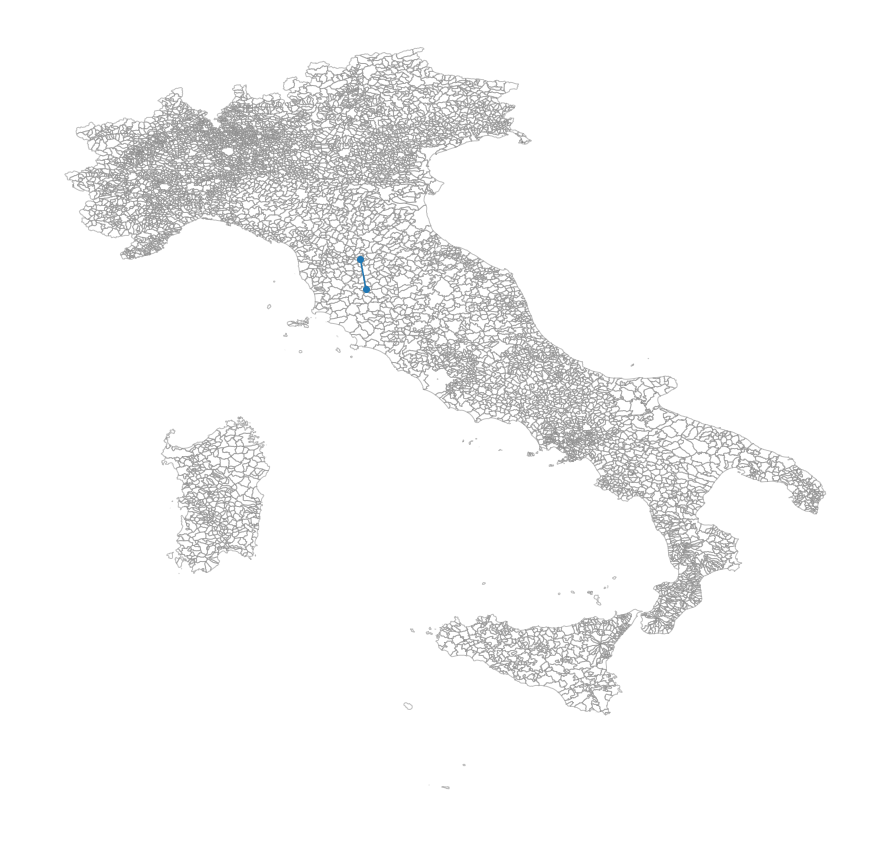

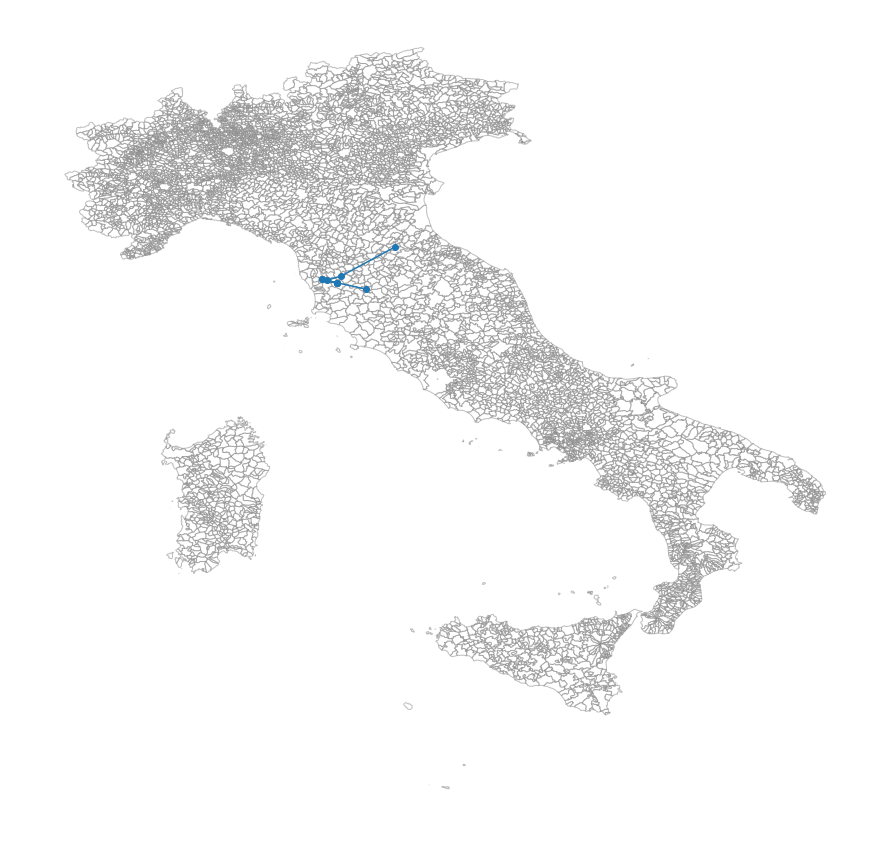

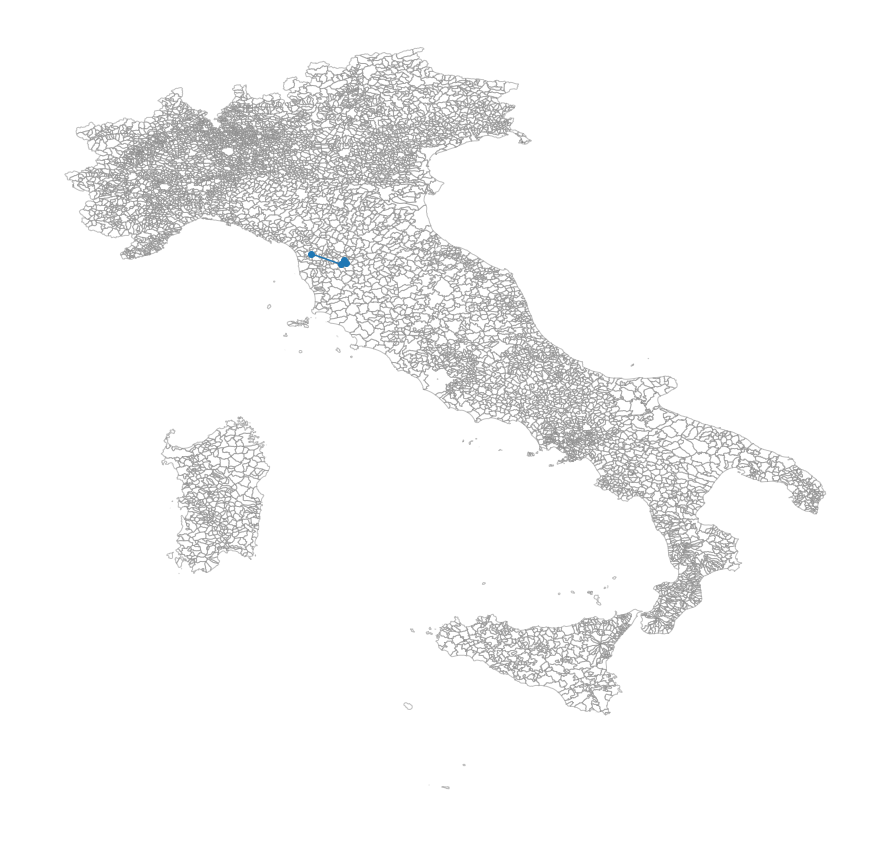

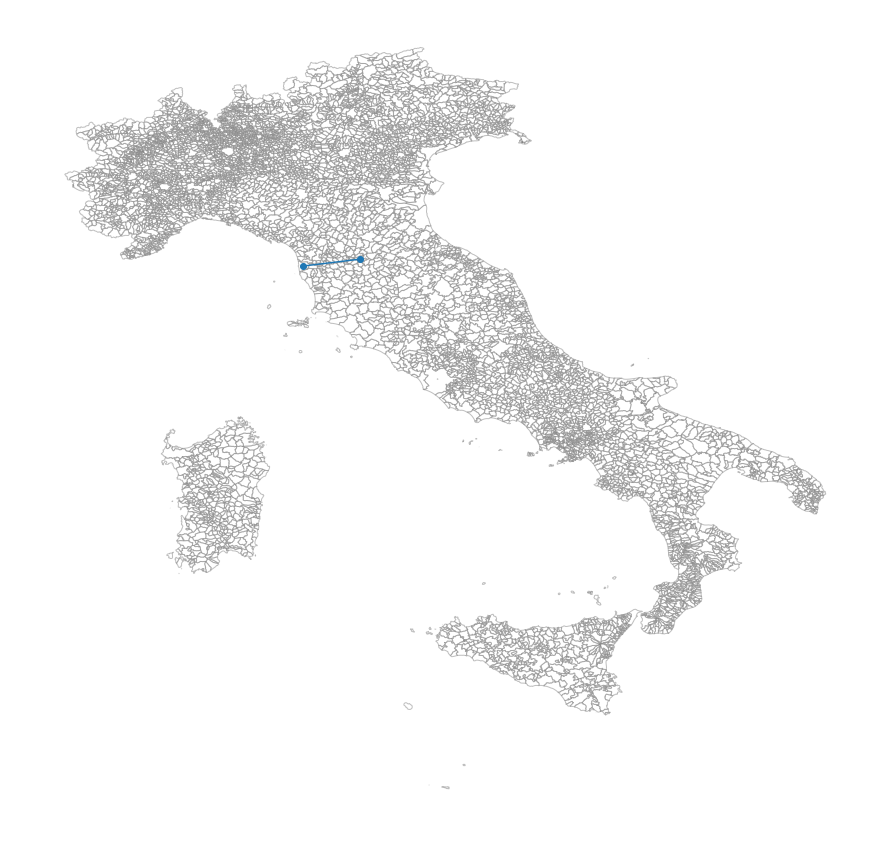

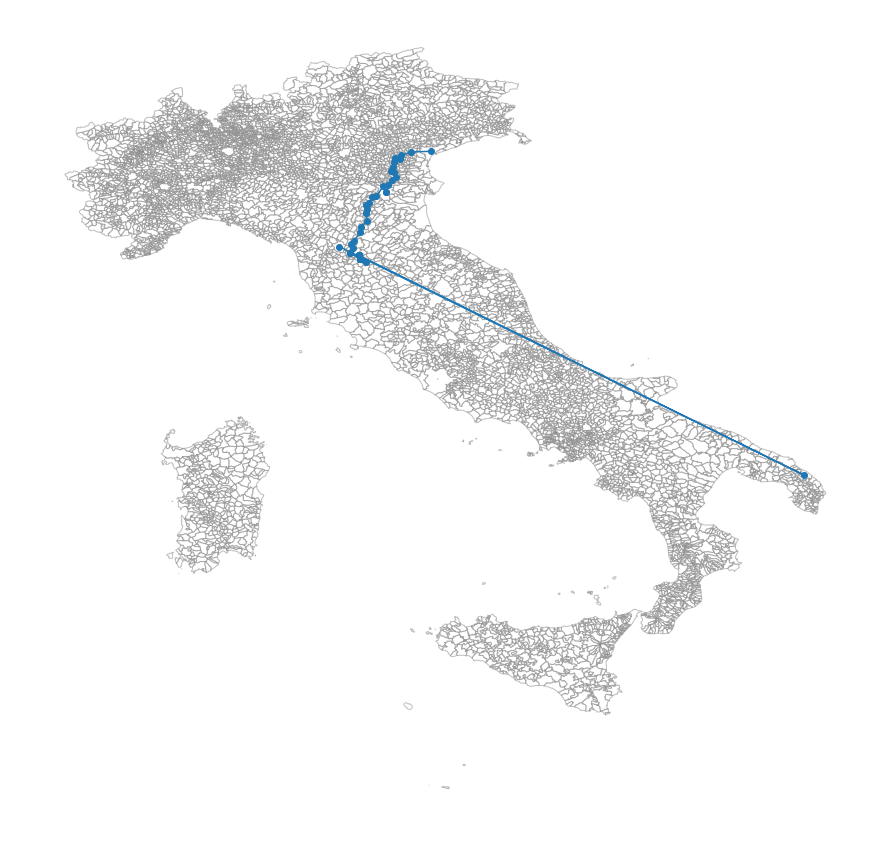

In [259]:
for trip in df_trips['com_locs_new'].tolist():
    function_for_KM(list_of_comunes=list(map(int, trip.split(', '))))

In [13]:
# colormap

from colorsys import hls_to_rgb
def get_distinct_colors(n):
    colors = []
    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))
    return colors

n=4
cs=get_distinct_colors(n)
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)

In [11]:
pd_coord_GO_CROATIA = pd.read_csv('/mnt/data/shared/coordinates_for_bruno_in_florence_after_croatia_won.csv')
pd_data_from_yanbing = pd.read_csv('/mnt/data/shared/customer_clustering_label.csv')
pd_coord_GO_CROATIA.head()

Unnamed: 0       lats       lons  lats_std  lons_std
0           0  43.397211  10.520373  0.714499  0.592908
1           1  43.646491  10.895958  0.868664  0.652753
2           2  43.378533  10.860348  1.067853  0.750051
3           3  40.591629  14.681979  1.543594  1.326501
4           4  43.370743  11.407496  0.784854  0.664668

In [17]:
pd_data_from_yanbing_red = pd_data_from_yanbing[['avg_lat', 'avg_lon', 'top_lat', 'top_lon', 'label']]
pd_data_from_yanbing_red.head()

avg_lat    avg_lon  top_lat  top_lon  label
0  43.772100  11.263993  43.7721  11.2640      3
1  43.025719  11.142990  43.0486  11.2900      3
2  44.008511  10.534599  43.9483  10.4758      3
3  43.156910  11.313968  42.9222  11.5706      3
4  43.741247  11.206776  43.7696  11.2597      3

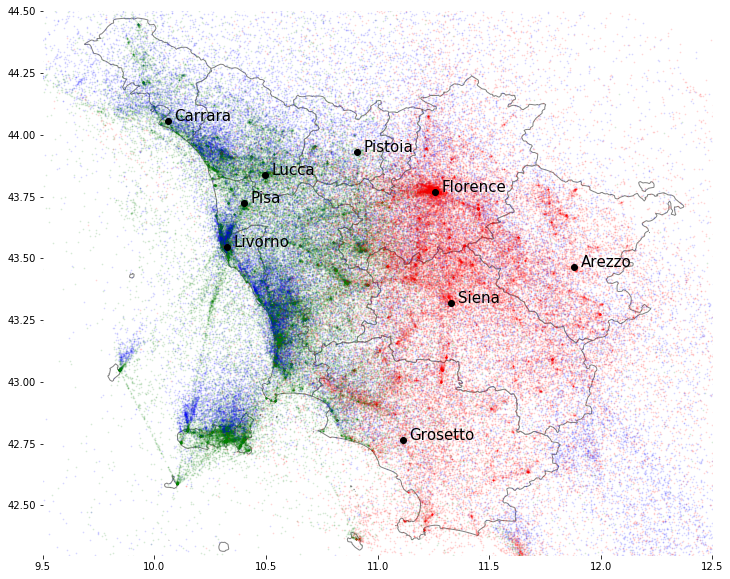

In [76]:
# yanbing stuff


lat_mean = np.array(pd_coord_GO_CROATIA['lats'])
lon_mean = np.array(pd_coord_GO_CROATIA['lons'])

lat_std = np.array(pd_coord_GO_CROATIA['lats_std'])
lon_std = np.array(pd_coord_GO_CROATIA['lons_std'])

fig = plt.figure(figsize=(12, 10))
ax = plt.gca()

cluster = pd_data_from_yanbing_red[pd_data_from_yanbing_red['label'] == 0]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'go', markersize=0.9, alpha=0.1)
  
#cluster = pd_data_from_yanbing_red[pd_data_from_yanbing_red['label'] == 1]
#plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'bo', markersize=0.5, alpha=0.3)

#cluster = pd_data_from_yanbing_red[pd_data_from_yanbing_red['label'] == 2]
#plt.plot(cluster['top_lon'].iloc[:], cluster['top_lat'].iloc[:], 'go', markersize=0.5, alpha=0.3)

cluster = pd_data_from_yanbing_red[pd_data_from_yanbing_red['label'] == 4]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'bo', markersize=0.9, alpha=0.1)

cluster = pd_data_from_yanbing_red[pd_data_from_yanbing_red['label'] == 3]
plt.plot(cluster['avg_lon'].iloc[:], cluster['avg_lat'].iloc[:], 'ro', markersize=0.9, alpha=0.1)
    
    
gdf_pro_tus.plot(ax=ax, color='white', edgecolor='gray', alpha=0.99)
important_cities(df_impcit)
 
plt.ylim([42.3, 44.5])
plt.xlim([9.5, 12.5])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False) 

NameError: name 'self' is not defined

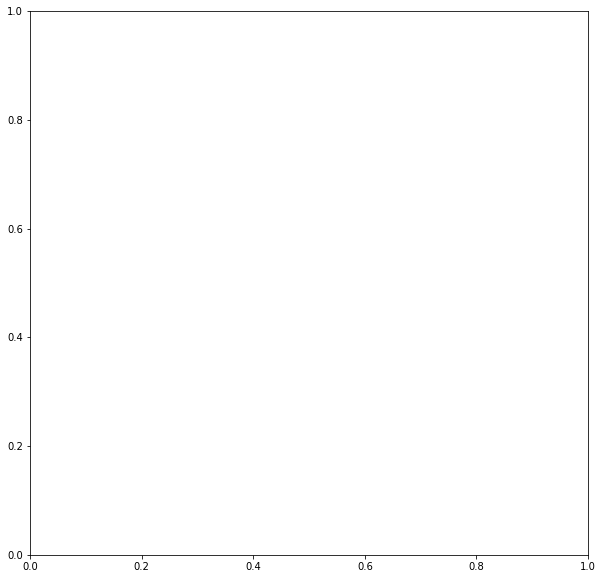

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

map 

cities_path=r"/mnt/data/shared/important_cities.csv"
df_cities = pd.read_csv(cities_path)

for i, name in enumerate(list(df_cities.city)):
    plt.plot(df_cities.long[i], df_cities.lat[i],
                    marker=self.city_marker,
                     color=self.city_markercolor,
                     markersize=self.city_markersize)

    plt.annotate(name,
                         (df_cities.long[i]+0.03, df_cities.lat[i]),
                         fontsize=self.fontsize)


gdf_ter_tus.plot(ax=ax, color='white', edgecolor='gray')
important_cities(df_impcit)

plt.axis('off')